# Validation Testing
The purpose of this notebook is to test the validation scores of the best found solutions at the end of the GA.
This figure was made using see-classify with hash `34abb8bb0d7a89716c194bcb993e4d92582fb1e9`.

You may have already generated the necessary data files for this notebook.

To generate data files, run:
- for sklearn
```bash
sbatch run_generate_gensearch_data.sb -m sklearn -n 10 -p 10
```
- for dhahri
```bash
sbatch run_generate_gensearch_data.sb -m dhahri -n 100 -p 100
```
to generate files for genetic search using 10 generations and population size of 10
for the sklearn tutorial and 100 generations with population size of 10 respectively
for the Breast Cancer Wisconsin (Diagnostic) Dataset.

The `-n` and `-p` flags control number of generations and population sizes
respectively.

In [1]:
# Path hack so that we can import see library.
import sys, os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
# Set data files path names
slurm_id = 30621493
hof_file = f"../dhahri_2019_hof_100_100_{slurm_id}.csv"
population_file = f"../dhahri_2019_population_100_100_{slurm_id}.csv"

In [3]:
import pandas as pd
import numpy as np
import ast
from see import classifiers
from see.classifier_helpers.helpers import generate_train_test_set
from sklearn.preprocessing import StandardScaler, label_binarize

hof_df = pd.read_csv(hof_file, header=None, delimiter=";")
population_df = pd.read_csv(population_file, header=None, delimiter=";")

best_hof_individuals = hof_df[hof_df[0] == 100].to_numpy()
best_hof = list(map(ast.literal_eval, best_hof_individuals[:, 3]))

# Breast Cancer Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
data = pd.read_csv(url, header=None)

X = data.iloc[:, 2:].to_numpy()

y = data[1].to_numpy()
y = label_binarize(y=y, classes=["B", "M"]).ravel()

# Preprocess data
X = StandardScaler().fit_transform(X)

temp = generate_train_test_set(X, y, test_size=0.2)
validation_set = temp.testing_set
temp = generate_train_test_set(temp.training_set.X, temp.training_set.y, test_size=0.25)
training_set = temp.training_set
testing_set = temp.testing_set

In [4]:
# learning curve
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes = np.linspace(30, len(training_set.X), num=10, dtype=int)
validation_matrix = np.zeros((len(best_hof), len(train_sizes)))
train_matrix = np.zeros((len(best_hof), len(train_sizes)))

for index, individual in enumerate(best_hof):
    clf_test = classifiers.Classifier.algorithmspace[individual[0]](individual)
    clf = clf_test.create_clf()
    test_scores = np.zeros(len(train_sizes))
    train_scores = np.zeros(len(train_sizes))

    for i, portion in enumerate(train_sizes):
        temp_X = training_set.X[0:portion]
        temp_y = training_set.y[0:portion]
        clf.fit(temp_X, temp_y)

        train_score = clf.score(temp_X, temp_y)
        train_scores[i] = 1 - train_score

        validation_score = clf.score(validation_set.X, validation_set.y)
        test_scores[i] = 1 - validation_score
    validation_matrix[index, :] = test_scores
    train_matrix[index, :] = train_scores
    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

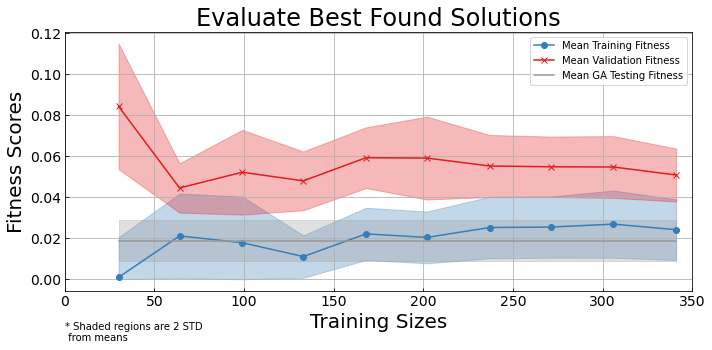

In [15]:
import matplotlib.pyplot as plt

train_scores_mean = np.mean(train_matrix, axis=0)
train_scores_std = np.std(train_matrix, axis=0)
test_scores_mean = np.mean(validation_matrix, axis=0)
test_scores_std = np.std(validation_matrix, axis=0)

plt.figure(figsize=(10, 5))

# Plot learning curve
plt.grid()

# '#999999', '#e41a1c', '#dede00' color blind friendly colors
#'f781bf', '#a65628', '#984ea3'
alpha = 0.3
train_low_bound = train_scores_mean - 2 * train_scores_std
train_low_bound[train_low_bound < 0] = 0  # Remove negative values


blue = "#377eb8"
red = "#e41a1c"
gray = "#999999"

plt.fill_between(
    train_sizes,
    train_low_bound,
    train_scores_mean + 2 * train_scores_std,
    alpha=alpha,
    color=blue,
)

plt.plot(
    train_sizes, train_scores_mean, "o-", color=blue, label="Mean Training Fitness"
)

plt.fill_between(
    train_sizes,
    test_scores_mean - 2 * test_scores_std,
    test_scores_mean + 2 * test_scores_std,
    alpha=alpha,
    color=red,
)

plt.plot(
    train_sizes, test_scores_mean, "x-", color=red, label="Mean Validation Fitness"
)

# Plot Expected Region during GA
ga_mean = np.repeat(best_hof_individuals[:, 2].mean(), len(train_sizes))
ga_std = np.repeat(best_hof_individuals[:, 2].std(), len(train_sizes))

plt.fill_between(
    train_sizes, ga_mean - 2 * ga_std, ga_mean + 2 * ga_std, alpha=alpha, color=gray
)

plt.plot(
    train_sizes,
    ga_mean,
    "-",
    color=gray,
    label="Mean GA Testing Fitness",
    linewidth=1.5,
)

plt.xlim(0, 350)

plt.legend(loc="best")

plt.tick_params(which="both", direction="in", labelsize=14)

plt.title("Evaluate Best Found Solutions", fontdict={'fontsize': 24})

plt.xlabel("Training Sizes", fontdict={'fontsize': 20})
plt.ylabel("Fitness Scores", fontdict={'fontsize': 20})

plt.text(0, -0.03, "* Shaded regions are 2 STD\n from means")
plt.tight_layout()